# Water Observations from Space (WOfS) for flow percentiles of HRS stream gauges (automated retrieval from BoM)¶

This notebook creates a flow duration curve (FDC) and examines Water Observation from Space (WOfS) for specified flow percentage exceedance ranges. Additionally, WOfS can be used to examine inbank and overbank streamflow.

Daily streamflow information and stream gauge coordinates are retrieved directly from the Bureau of Meteorology (BoM) Hydrologic Reference Stations (HRS) website, http://www.bom.gov.au/water/hrs/. Streamflow data is used to calculate the percentage exceedance statistic (the percentage of time that the streamflow value is equalled or exceeded by all other streamflow values within the data set).

The date of streamflow measurement and date of avaliable satellite imagery are matched, for the location of the gauge. A flow duration curve plot is created. The user can specify a percentile range of interest and an image is created that shows the percentage of time that water is present (or absent) around the stream gauge, during the specified percentile range of interest. 

Finally the number of pixels that contain water, within each scene, are counted and plotted against percentage exceedance for that scene. This plot can be used to eyeball where/if the amount of the water on the ground increases dramatically, and therefore be used to estimate the point where flow extends over and past the streambank. 

"###" indicates fields that require user modification.

"##" indicates fields that may require user modification, e.g. graphic edits/preferences.

"#" indicates a cell title or description of code. No modification is required.

Code written in May 2017 by Erin Telfer with support from Leo Lymburner, Damien Ayers and Biswajit Bala.

The notebook was completed as a graduate program project at Geoscience Australia. If you find a mistake or if you have any suggestions, please contact erin.telfer@ga.gov.au. Alternatively, please contact leo.lymburner@ga.gov.au.

In [1]:
#Import libraries
%pylab notebook

import datacube 
from datacube import Datacube
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

import xarray as xr
import pandas as pd
import numpy as np
import datetime
import csv
import os

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

import rasterio
from pyproj import Proj, transform
import urllib
from dateutil import tz
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')
dcwofs = Datacube(config='/g/data/r78/ext547/wofscube.conf')

Populating the interactive namespace from numpy and matplotlib


## Retrieve stream data and coordinates from the BoM website
The URL for the data is set using the gauge_of_interest

In [2]:
#Specify stream gauge of interest.

###User modification: Enter the ID code for the gauge of interest. ID code can be viewed on 
###http://www.bom.gov.au/water/hrs/ e.g. for 'Diamantina River at Birdsville' the ID code is 'A0020101'

gauge_of_interest= 'A0020101'

In [3]:
#Url is used to retrieve daily streamflow data for the gauge_of_interest    
url = 'http://www.bom.gov.au/water/hrs/content/data/'+gauge_of_interest+'/'+gauge_of_interest+'_daily_ts.csv'
gaugedata = pd.read_csv(url, comment='#')
print (gaugedata)

             Date  Flow (ML) Bureau QCode
0      1966-10-19     0.0000            A
1      1966-10-20     0.0000            A
2      1966-10-21     0.0000            A
3      1966-10-22     0.0000            A
4      1966-10-23     0.0000            A
5      1966-10-24     0.0000            A
6      1966-10-25     0.0000            A
7      1966-10-26     0.0000            A
8      1966-10-27     0.0000            A
9      1966-10-28     0.0000            A
10     1966-10-29     0.0000            A
11     1966-10-30     0.0000            A
12     1966-10-31     0.0000            A
13     1966-11-01     0.0000            A
14     1966-11-02     0.0000            A
15     1966-11-03     0.0000            A
16     1966-11-04     0.0000            A
17     1966-11-05     0.0000            A
18     1966-11-06     0.0000            A
19     1966-11-07     0.0000            A
20     1966-11-08     0.0000            A
21     1966-11-09     0.0000            A
22     1966-11-10     0.0000      

In [4]:
#Url is used to retrieve stream gauge location coordinates. Coordinates are reprojected to Australian Albers   

#Search url to find coordinates 
txt = urllib.request.urlopen(url).read()
txt = str(txt)
sg_lon = txt.split('"Location:", ')[1].split(',"degrees E",')[0]
sg_lon=float(sg_lon)
sg_lat = txt.split(',"degrees E", ')[1].split(',"degrees S"')[0]
sg_lat= "-"+sg_lat
sg_lat=float(sg_lat)

#Reproject to Australian Albers
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
sg_x,sg_y = transform(inProj,outProj,sg_lon,sg_lat)

print ("Geographic: " + str(sg_lon)+', '+ str(sg_lat))
print ("Australian Albers: "+ str(sg_x)+', '+str(sg_y))

Geographic: 139.3667, -25.9088
Australian Albers: 728893.3995514876, -2825460.0787998526


## Complete Datacube query

In [5]:
#Spatiotemporal range and wavelengths/band of interest are defined

#Temporal range is defined
start_of_epoch = '1987-01-01'
end_of_epoch =  '2014-12-31'

#Wavelengths/bands of interest are defined
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Landsat sensors of interest are defined
sensors = ['ls8',
    'ls7',
    'ls5' ] 

#Create bounding box around the location of the stream gauge
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [6]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

## Complete Datacube extraction
The extracted data is first filtered using the criteria in "mask_components". The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_threshold" are discarded. 

In [7]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_threshold = 0.90  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will be discarded that have less than the cloud threshold worth of image.
    
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_threshold
        
    #Discard data that does not meet the cloud_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [8]:
#Check the output
sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 302, x: 422, y: 471)
 Coordinates:
   * time     (time) datetime64[ns] 1987-05-22T00:01:19.500000 ...
   * y        (y) float64 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 ...
   * x        (x) float64 7.236e+05 7.237e+05 7.237e+05 7.237e+05 7.237e+05 ...
 Data variables:
     green    (time, y, x) float64 1.571e+03 1.571e+03 1.632e+03 1.571e+03 ...
     red      (time, y, x) float64 2.364e+03 2.417e+03 2.47e+03 2.47e+03 ...
     nir      (time, y, x) float64 2.992e+03 2.992e+03 3.12e+03 3.056e+03 ...
     swir1    (time, y, x) float64 3.842e+03 3.976e+03 4.11e+03 4.066e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 60, x: 422, y: 471)
 Coordinates:
   * time     (time) datetime64[ns] 1999-07-18T00:30:07.500000 ...
   * y        (y) float64 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 ...
   * x        (x) flo

In [9]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [10]:
# Check whether the concatenation worked
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 394, x: 422, y: 471)
Coordinates:
  * y        (y) float64 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 ...
  * x        (x) float64 7.236e+05 7.237e+05 7.237e+05 7.237e+05 7.237e+05 ...
  * time     (time) datetime64[ns] 1987-05-22T00:01:19.500000 ...
Data variables:
    green    (time, y, x) float64 1.571e+03 1.571e+03 1.632e+03 1.571e+03 ...
    red      (time, y, x) float64 2.364e+03 2.417e+03 2.47e+03 2.47e+03 ...
    nir      (time, y, x) float64 2.992e+03 2.992e+03 3.12e+03 3.056e+03 ...
    swir1    (time, y, x) float64 3.842e+03 3.976e+03 4.11e+03 4.066e+03 ...
    product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 723625.00|\n| 0.00,-25.00,-2819575.00|\n| 0.00, ...

## Process stream gauge information
Calculate the percentiles of stream flow, and sort the dataframe according to date

In [11]:
#Calculate "percentage exceedance" (perexc) for stream flow values

all_data = gaugedata #Import streamflow data from the gauge of interest
all_data= all_data.rename(columns={'Flow (ML)':'flow', 'Date':'date'})  #Rename flow and date columns
all_data = all_data.sort_values('flow', ascending=[False]) #Sort data by flow value
all_data['rank'] = np.arange(len(all_data)) + 1 #Create rank column and values
all_data['perexc'] = 100*(all_data['rank'])/(len(all_data)+1) #Calculate probability of each rank
all_data= all_data.sort_values(['date']) #Sort data by date
all_data=all_data.drop(all_data.columns[[2]], axis=1) #Remove "Bureau QCode" column
all_data['date']=pd.to_datetime(all_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format
all_data.date = all_data.date.map(lambda t: t.strftime('%Y-%m-%d')) #Change datetime format

## Return just the time and sensor product information from the Datacube extraction

In [12]:
product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

## Match the date of stream flow data to the date where satellite information exists¶

In [13]:
subset_data = pd.merge(all_data, product_time, left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

In [14]:
subset_data['date']=pd.to_datetime(subset_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format

# Create flow duration curve (FDC)

In [15]:
#Prepare flow and percentage exceedance variables for plotting on FDC

#Preapre all data
sorted_a_flow=sorted(all_data.flow, reverse=True)
sorted_a_pe=sorted(all_data.perexc)

#Prepare the matched subset data
sorted_s_flow=sorted(subset_data.flow, reverse=True)
sorted_s_pe=sorted(subset_data.perexc)

<IPython.core.display.Javascript object>


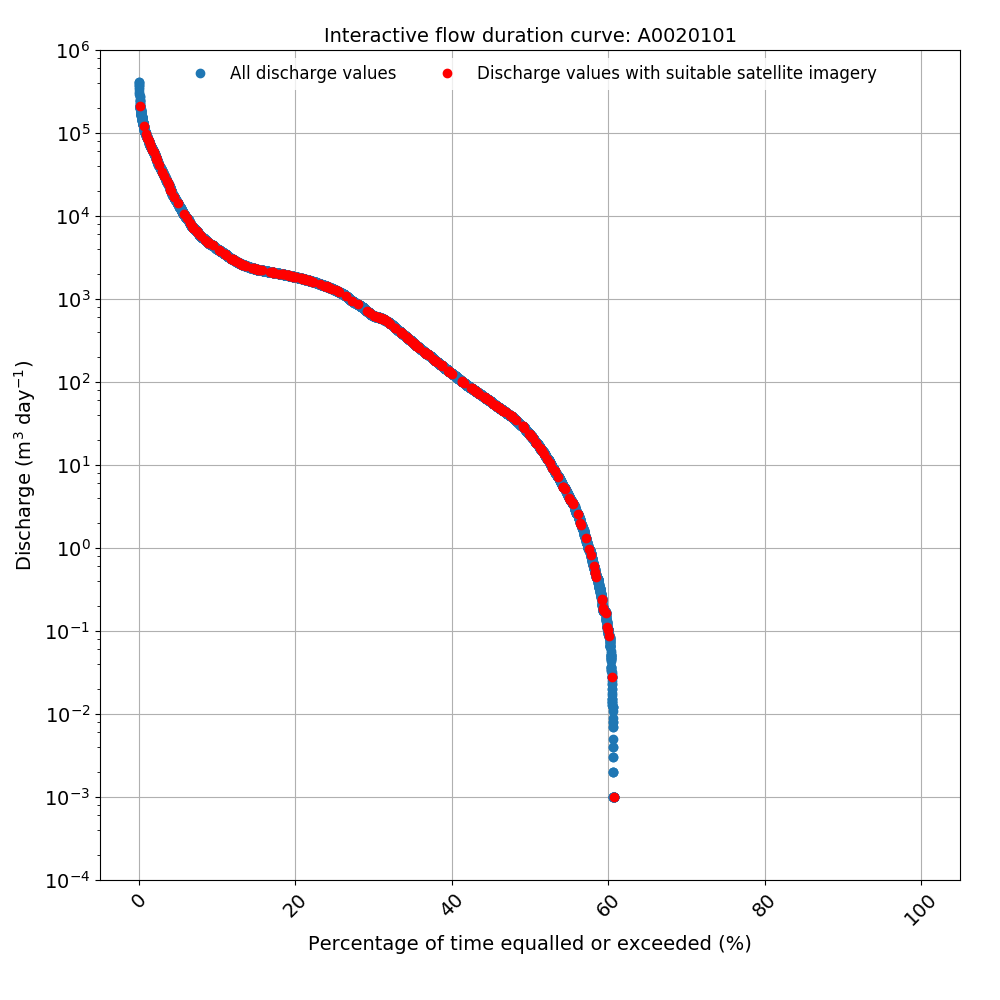

In [16]:
#Creation of FDC plot. Please note that this graph is not interactive

#Plot details
fig = plt.figure(figsize=(10,10)) #Edit size of plot ##User should format as required
plt.title('Interactive flow duration curve: '+gauge_of_interest, size=14) #Plot title ##User should format if required
plt.grid(True) #Add gridlines to the figure
pyplot.yscale('log') #set up Y axis as a log scale
plt.subplots_adjust(left=0.10, right=0.96, top=0.95, bottom=0.12) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white')  #Make border white ##User should format if required
fig.patch.set_alpha(0.99)  #Make border white ##User should format if required

#create plot of percent exceedance
plt.plot(sorted_a_pe,sorted_a_flow,'o',label= 'All discharge values')  #plot all discharge values ##User should format series if required
plt.plot(sorted_s_pe,sorted_s_flow,'ro',label='Discharge values with suitable satellite imagery') #plot matched discharge values ##User should format series if required

#axis and legend details
plt.axis([-5, 105, 0.0001, 1000000])  ###User modification: set axis discharge values appropriate for streamflow range
plt.xticks(rotation=45,size=14) #Rotate and format size of date labels ##User should format if required
plt.yticks(size=14) #Rotate and format size of date labels ##User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)', size=14) #Set Y label
plt.xlabel('Percentage of time equalled or exceeded (%)', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=2, loc=9, fontsize=12) #Set legend location on plot ##User should format if required

plt.show() #Show plot

In [17]:
# #Save figure
# ###User modification: edit directory to save figure
# %cd /g/data/r78/ext547/Output/FDC/ 
# plt.savefig('FDC_'+gauge_of_interest+'_1pct_CFI.jpg') ##User should format file name if required

# Creation of WOfS imagery
Set the flow percentile range of interest, create the Datacube query and create the WOfS image

In [46]:
#Set the percentage exceedance range of interest. The WOfS image will only include scenes from within this flow range
###User modification: set flow percentage exceedance range of interest between 0 to 100%
wofs_range_min = 5 #minimum value to include
wofs_range_max = 10 #maximum value to include

In [47]:
#Create Datacube query for WOfS event of interest

#EITHER... Create a large bounding box around the location of the stream gauge
###User modification: change area of interest to suit gauge location in relation to satellite pass
# lat_max = sg_lat + 0.5
# lat_min = sg_lat - 0.5
# lon_max = sg_lon + 0.7
# lon_min = sg_lon - 0.4

#...OR... create smaller bounding box around the location of the stream gauge
###User modification: change area of interest to suit gauge location in relation to satellite pass
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05

#Create query
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [48]:
#Search for scenes that fit within specified percentage exceedance range
subset_data['date']=pd.to_datetime(subset_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format
FDC_subset=subset_data[subset_data['perexc'].between(wofs_range_min, wofs_range_max, inclusive=True)] #Return percentage exceedance range of interest
FDC_subset_count=len(FDC_subset.index) #Define the number of scenes within this range 

In [49]:
#Create a query to store spatiotemporal information from the previous landsat query
wofs_query = query

In [50]:
#Retrieve wofs data array for each date specified within the FDC range of interest and save to multiple arrays

wofs_subset = {}
for i in range(len(FDC_subset)):
    wofs_query['time'] = (FDC_subset.date.iloc[i]+ datetime.timedelta(days=-2)), (FDC_subset.date.iloc[i]+ datetime.timedelta(days=+2))
    wofs_data = dcwofs.load(product = 'old_wofs', **wofs_query)
    wofs_subset[i]=wofs_data

In [51]:
#Concatenate (join) the data from the different WOfS scenes together and sort so that observations are sorted 
#by time

xr_wofs = xr.DataArray(wofs_subset)
list(wofs_subset.values())
wofs_subset2 = {k: x for (k, x) in wofs_subset.items() if x}
wofs_subset3=xr.concat(wofs_subset2.values(),dim='time')

In [52]:
#Remove all values that are not defined as "wet water" (value of 128)
wofs128=wofs_subset3
wofs128['water']=wofs_subset3.water.where(wofs_subset3.water==128)

In [53]:
#Add water values for each pixel and turn into a percentage

#Add the water value for each pixel in the array over time
wofs128_v2 = wofs128.sum(dim = 'time')

#Take the average of water value at each pixel and turn into a percentage
wofs128_v2 = wofs128_v2/ 128
wofs128_v2 = wofs128_v2 / FDC_subset_count
wofs128_v2 = wofs128_v2*100

In [54]:
#Set up the WOfS colour ramp and corresponding thresholds
wofs_cmap = mpl.colors.ListedColormap(['#C8B97D','#B3E5FC','#81D4FA','#4FC3F7','#29B6F6','#039BE5',
                                       '#0288D1','#0277BD', '#01579B','#1A237E','#02033a','#5e0799'])##User should format as required
wofs_bounds = [0.1,0.1,5,10,20,30,40,50,60,70,80,90,100] ##User should format as required
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


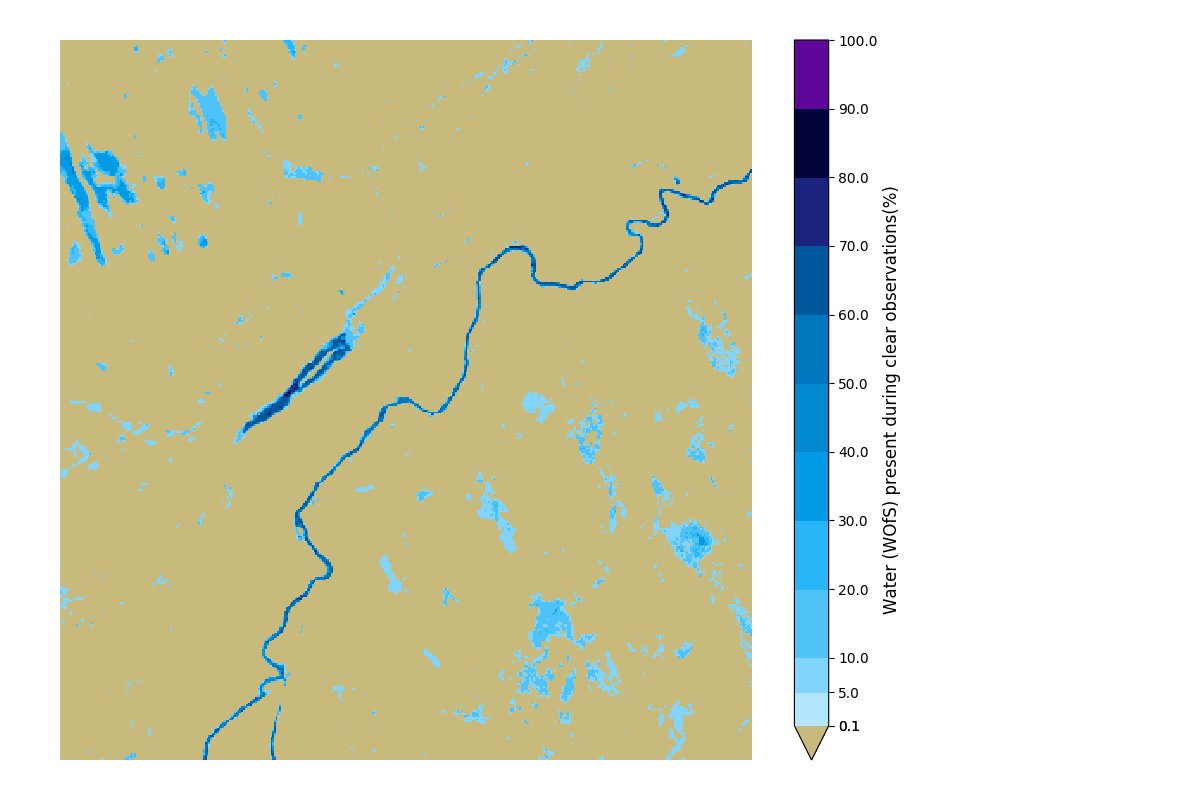

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/matplotlib/colorbar.py:871: RuntimeWarning: invalid value encountered in true_divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db


In [55]:
#Create a WOfS image for the specified percentage exceedance range of interest. 
#The image shows the percentage of time each pixel contains water during the specified range of interest

#Create widget that enables interaction with plot.
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y) 
fig.canvas.mpl_connect('button_press_event', callback)

#Create image
fig = plt.figure(figsize =(12,8)) #Set figure size ##User should format if required
i= wofs128_v2.water.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)#create WOfS image

#Format image
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar
fig.colorbar(i, ticks=wofs_bounds, spacing='proportional', 
             extend='min').set_label(label='Water (WOfS) present during clear observations(%)',
             size=12) #Add definable colour bar
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border size
fig.patch.set_facecolor('white') #Ensure border is white
fig.patch.set_alpha(0.99) #Ensure border is white
plt.axis('off') #Remove axis

plt.show() #Create image
display(w) #Create image

In [56]:
# #save figure
# ###User modification: edit directory to save figure
# %cd /g/data/r78/ext547/Output/wofs/FDC/
# plt.savefig('FDC_WOfS_5-10_small.jpg') ##User should format file name if required

/g/data1/r78/ext547/Output/wofs/FDC


# Examination of overbank flow

In [29]:
#Take the sum of water present at each pixel over the specified flow percentile range
wofs_area_ar = wofs128.sum(dim = ['longitude','latitude']) #sum pixels 

In [30]:
#process data to allow the merge of streamflow data with WOfS data
wofs_area_py = wofs_area_ar.to_dataframe() #Convert wofs array into a pandas dataframe
wofs_area_py.index = wofs_area_py.index + pd.Timedelta(hours=10) #Roughly convert to time to local time
wofs_area_py.index = wofs_area_py.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

In [31]:
#reformat date of streamflow data prior to merge
subset_data.date = subset_data.date.map(lambda t: t.strftime('%Y-%m-%d')) #Change datetime format

In [32]:
#Merge streamflow and WOfS dataframe
wofs_area = pd.merge(subset_data, wofs_area_py, left_on= 'date', right_index=True, how='inner') #merge
wofs_area=wofs_area[~wofs_area.index.duplicated(keep='last')]  #drop duplicates from WOfS dataframe (duplicates occur because of how WOfS data was loaded (searching days either side of the satellite pass))
wofs_area = wofs_area.sort_values('perexc', ascending=[True]) #Sort data by percentage exceedance

<IPython.core.display.Javascript object>


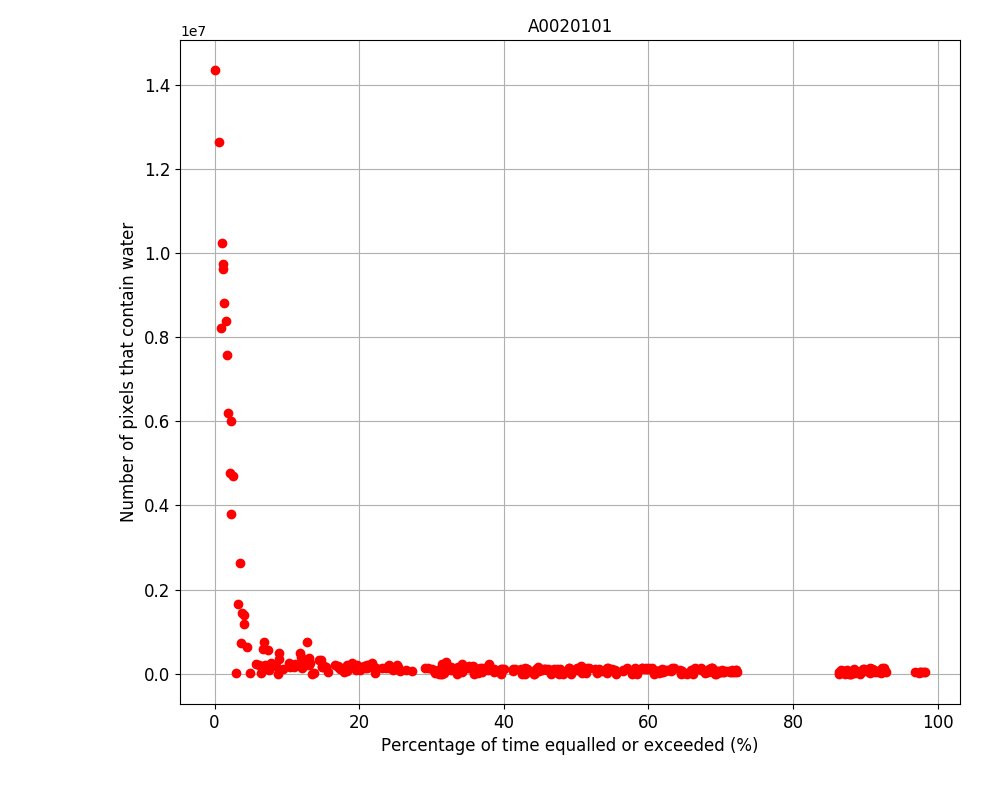

In [33]:
#Creation of plot that shows the amount of water pixels for each percentage discharge value

#Plot details
fig = plt.figure(figsize=(10,8)) #Edit size of plot ##User should format as required
plt.title(gauge_of_interest, size=12) #Plot title ##User should format if required
plt.grid(True) #Add gridlines to the figure
plt.subplots_adjust(left=0.18, right=0.96, top=0.95, bottom=0.12) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white')  #Ensure border white ##User should format if required
fig.patch.set_alpha(0.99)  #Ensure border white ##User should format if required

#Create plot
plt.plot(wofs_area.perexc, wofs_area.water, 'ro')  #Plot percentage exceedance vs. number of pixels  ##User should format series if required

#Axis and legend details
plt.xticks(size=12) #Format size of date labels ##User should format if required
plt.yticks(size=12) #Format size of date labels ##User should format if required
plt.ylabel('Number of pixels that contain water', size=12) #Set Y label
plt.xlabel('Percentage of time equalled or exceeded (%)', size=12) #Set X label

plt.show() #Show plot

In [34]:
# #Save figure
# ###User modification: edit directory to save figure
# %cd /g/data/r78/ext547/Output/wofs/overbank
# plt.savefig(gauge_of_interest+'.jpg') #User should format file name, if required

/g/data1/r78/ext547/Output/wofs/overbank
